In [1]:
import sys
sys.path.append('..')

In [20]:
import pickle
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt

from trickster.wfp_helper import load_data, extract

In [19]:
model_pickle_names = ['../models/small_model_{}.pkl'.format(i) for i in range(1, 5)]
models = [pickle.load(open(filename, 'rb')) for filename in model_pickle_names]

In [5]:
coefs = [model.coef_[0] for model in models]

[]

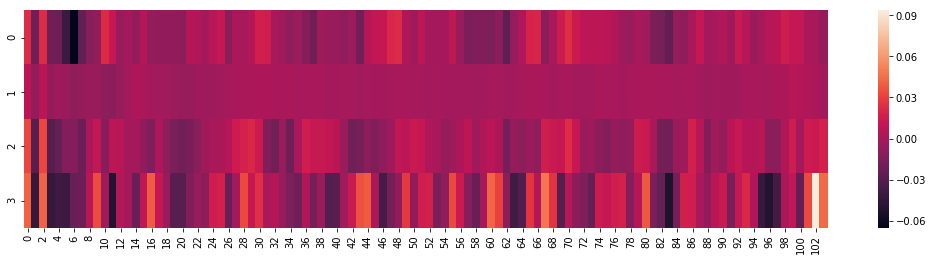

In [10]:
fig, ax = plt.subplots()
fig.set_figwidth(18)

sns.heatmap(coefs, ax=ax)

plt.plot()

In [ ]:
X, y = load_data('../data/knndata')

In [16]:
X_features = [extract(trace) for trace in X] 

In [18]:
model_perfs = [model.score(X_features, y) for model in models]
for acc in model_perfs: print(acc)

0.689
0.7038888888888889
0.7285555555555555
0.649


In [22]:
adv_results_pickle_names = ['../out/results_small_model_{}.pkl'.format(i)
                            for i in range(1, 5)]
adv_results = [pd.read_pickle(filename) for filename in adv_results_pickle_names]

In [29]:
model_robustness = []
for results_df in adv_results:
    robustness = results_df.nodes_expanded.mean()
    model_robustness.append(robustness)
model_robustness

[52.83519553072626, 53.19023136246787, 20.131498470948014, 51.582142857142856]